### Firstly, we download the index of WET files. Those files contain already extracted text not the raw responses.

In [1]:
!curl https://commoncrawl.s3.amazonaws.com/crawl-data/CC-MAIN-2019-09/wet.paths.gz --output wet.paths.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181k  100  181k    0     0   177k      0  0:00:01  0:00:01 --:--:--  177k


In [2]:
!gzip -d wet.paths.gz

In [3]:
!cat wet.paths | wc -l

64000


In [4]:
!head -n 10 wet.paths

crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00000.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00001.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00002.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00003.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00004.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00005.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00006.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-00007.warc.wet.gz
crawl-data/CC-MAIN-2019-09/segments/1550247479101.30/wet/CC-MAIN-20190215183319-20190215205319-0

### Based on index,  we download a WET file by 826 index.

In [5]:
!curl https://commoncrawl.s3.amazonaws.com/$(head -n 826 wet.paths | tail -n 1) --output 0826-warc.wet.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  124M  100  124M    0     0   687k      0  0:03:04  0:03:04 --:--:--  450k   0   806k      0  0:02:37  0:01:29  0:01:08  521k8M    0     0   746k      0  0:02:50  0:01:45  0:01:05  399k   0   705k      0  0:02:59  0:02:25  0:00:34 1564k      0  0:02:57  0:02:35  0:00:22  647k    0  0:03:02  0:02:59  0:00:03  529k


### We use 'warcat' python module to parse the file

In [116]:
import warcat.model

warc = warcat.model.WARC()
warc.load('0826-warc.wet.gz')
len(warc.records)

44574

### Then we parse the contents of the file and detect its language

In [117]:
import langdetect as ld
import numpy as np

langs = []
contents = []
for r in warc.records[1:]:
    content = bytes(r.content_block).decode('utf-8')
    contents.append(content)
    if content:
        try:
            langs.append(ld.detect(content[:256]))
        except ld.detector.LangDetectException as e:
            langs.append(np.NaN)
    else:
        langs.append(np.NaN)

### After it we extract target URIs and content length in bytes

In [118]:
from urllib.parse import urlparse

hosts = []
content_length = []

for r in warc.records[1:]:
    hosts.append(urlparse(r.header.fields['WARC-Target-URI']).netloc)
    content_length.append(int(r.header.fields['Content-Length']))
    

### Finally, we extract first and second level domains

In [5]:
import re

domain_l1 = []
domain_l2 = []

for h in hosts:
    parts = re.sub(r'\:\d+', '', h).split('.')
    domain_l1.append(''.join(parts[-1:]))
    domain_l2.append('.'.join(parts[-2:]))


### Having all the required data we create a DataFrame

In [119]:
import pandas as pd


warc_df = pd.DataFrame({'host': hosts,
                        'domain-l1': domain_l1,
                        'domain-l2': domain_l2,
                       'lang': langs,
                       'content-length': content_length})

warc_df.head()

,host,domain-l1,domain-l2,lang,content-length
0,000162.net,net,000162.net,zh-cn,3551
1,001design.it,it,001design.it,it,4056
2,010281.com,com,010281.com,zh-cn,5497
3,010kende.com,com,010kende.com,zh-cn,5347
4,01304.org,org,01304.org,zh-cn,1409


In [94]:
warc_df.describe(include='all')

,host,domain-l1,domain-l2,lang,content-length
count,44573,44573,44573,44550,44573.000000
unique,39174,336,33705,54,NaN
top,www.mapquest.com,com,co.uk,en,NaN
freq,18,20529,892,20277,NaN
mean,NaN,NaN,NaN,NaN,7167.920512
std,NaN,NaN,NaN,NaN,15992.126968
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,1889.000000
50%,NaN,NaN,NaN,NaN,3936.000000
75%,NaN,NaN,NaN,NaN,7580.000000


### Let's check whether we have failures in language detection

In [120]:
warc_df[warc_df['lang'].isna()]

,host,domain-l1,domain-l2,lang,content-length
898,apycomm.com,com,apycomm.com,NaN,101
2592,ckrnews.com,com,ckrnews.com,NaN,27272
2593,ckrnews.com,com,ckrnews.com,NaN,33520
2594,ckrnews.com,com,ckrnews.com,NaN,28074
8496,moe.gov.lk,lk,gov.lk,NaN,13559
9329,odiapua.com,com,odiapua.com,NaN,7698
9330,odiapua.com,com,odiapua.com,NaN,9542
12611,themuletowner.com,com,themuletowner.com,NaN,1
18249,www.klahan9.com.kh,kh,com.kh,NaN,8620
23989,at.moleskine.com,com,moleskine.com,NaN,4


### Then we check the all unique languages, hosts, domains. We also count the number of the metioned unique entities

In [121]:
warc_df['lang'].unique()

array(['zh-cn', 'it', 'en', 'de', 'ru', 'ko', 'es', 'ja', 'pt', 'nl',
       'vi', 'id', 'he', 'ca', 'sl', 'ar', 'uk', 'pl', 'cs', 'fr', 'el',
       'lt', 'bg', 'fa', 'ro', 'th', 'et', 'no', 'ne', 'fi', 'sk', 'hu',
       'hr', 'ur', 'sv', 'da', 'tr', 'mk', 'sq', 'tl', nan, 'zh-tw', 'lv',
       'bn', 'af', 'cy', 'ml', 'hi', 'so', 'kn', 'ta', 'sw', 'mr', 'te',
       'gu'], dtype=object)

In [122]:
len(warc_df['lang'].unique())

55

In [123]:
warc_df['domain-l1'].unique()

array(['net', 'it', 'com', 'org', 'xn--p1ai', 'ar', 'io', 'ua', 'jp',
       'ru', 'us', 'nl', 'vn', '159', '111', 'cn', '227', 'education',
       'by', 'biz', 'mobi', 'su', 'il', 'ch', 'info', 'cl', 'si', 'uk',
       '57', 'kz', 'kr', 'za', 'me', '31', 'lt', 'co', 'pl', 'eu', 'cz',
       'fr', 'au', 'gr', 'tv', '117', 'so', '218', 'uz', 'ir', '59',
       '149', 'in', 'ie', 'mx', 'sk', 'edu', 've', 'eg', 'at', 'pe', 'br',
       'hu', 'nu', 'es', 'rs', 'tk', 'se', 'ag', 'dk', 'be', 'int', 'ca',
       'de', 'nz', 'pt', 'site', 'tr', 'bh', 'ma', 'ga', 'xyz', 'ro',
       'id', 'media', 'md', 'ci', 'hk', 'eus', 'fi', 'xxx', 'zm', 'py',
       'gov', 'kg', 'hr', 'al', 'az', 'am', 'mn', 'tokyo', 'tn', 'cat',
       'lv', 'top', 'work', 'pro', 'cc', 'pk', 'tw', 'club', 'zw', 'gq',
       'win', 'ba', 'reviews', 'bg', 'ws', 'lu', 'my', 'pw', 'no', 'name',
       'tech', 'th', 'space', 'news', 'sg', 'ht', 'website', 'ge', 'iq',
       'gt', 'gal', 'cu', 'live', 'pf', 'cr', 'online', 'coff

In [124]:
len(warc_df['domain-l1'].unique())

336

In [125]:
len(warc_df['domain-l2'].unique())

33705

In [126]:
len(warc_df['host'].unique())

39174

### Next, we show disributions of language and L1 domains by content size

<Figure size 432x288 with 0 Axes>

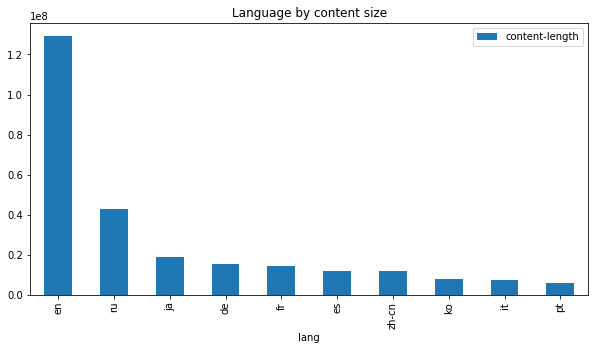

In [131]:
import matplotlib.pyplot as plt
    
plt.figure()

warc_df[['lang','content-length']].groupby('lang').sum().\
sort_values(ascending = False, by = 'content-length').\
head(10).plot.bar(title = "Language by content size", figsize=(10,5))

plt.show()

<Figure size 432x288 with 0 Axes>

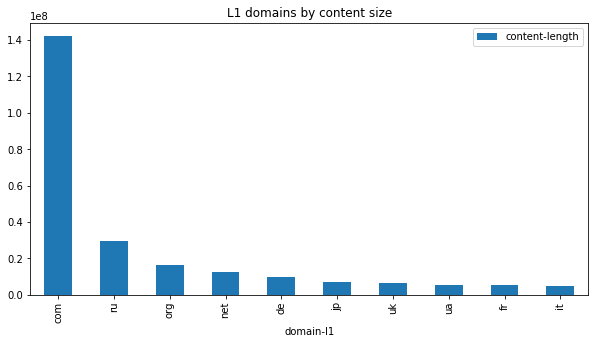

In [132]:
plt.figure()

warc_df[['domain-l1','content-length']].groupby('domain-l1').\
sum().sort_values(ascending = False, by = 'content-length').\
head(10).plot.bar(title = 'L1 domains by content size',figsize=(10,5))

plt.show()

### We see that the biggest L1 domain is 'com'. Let's check the distirbution of language in it.

<Figure size 432x288 with 0 Axes>

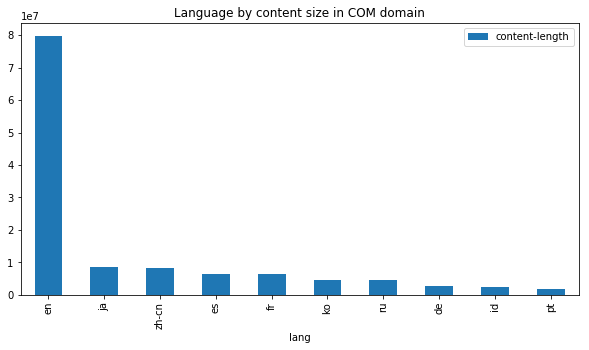

In [133]:
plt.figure()

warc_df[warc_df['domain-l1'] == 'com'][['lang', 'content-length']].groupby('lang').\
sum().sort_values(ascending = False, by = 'content-length').\
head(10).plot.bar(title  = 'Language by content size in COM domain', figsize=(10,5))

plt.show()

### Finally, we find out top 10 sites by content size and do simple word frequency analysis for each site.

In [114]:
top_hosts = warc_df[['host','content-length']].groupby('host').\
sum().sort_values(ascending = False, by = 'content-length').head(10)

top_hosts

,content-length
host,
addart.ru,959134
www.fashionmodeltalk.com,860286
homeplanasa.com,778936
ufdc.ufl.edu,708542
sportmarket.su,683132
www.tht.hu,578390
patents.google.com,541075
newsoftheday.ru,476461
londoonsheaaugustuvelik.tk,448444


In [129]:
import nltk
from nltk.tokenize import word_tokenize

def plot_host_fdist(host):
    words = []
    lang = set([])
    for idx, content in enumerate(contents):
        if hosts[idx] != host:        
            continue
        words.extend(word_tokenize(content))
        lang.add(langs[idx])
    fdist = nltk.FreqDist([word for word in words if word.isalpha()])  
    plt.figure(figsize=(10,5))
    fdist.plot(30, cumulative = True, title = "Host: {}; Total words: {}; Langs {}".format(host, fdist.N(), lang)) 

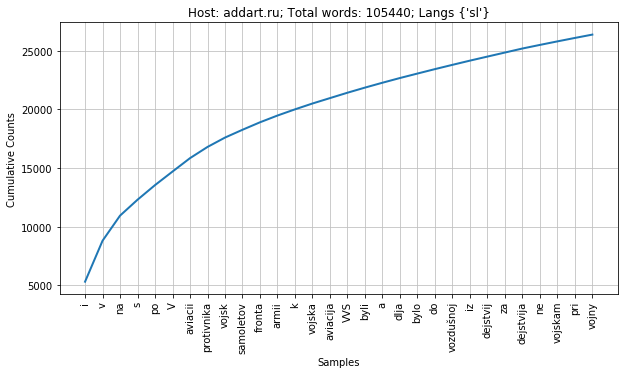

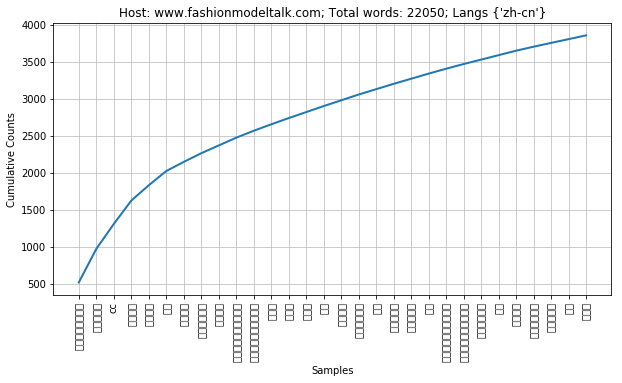

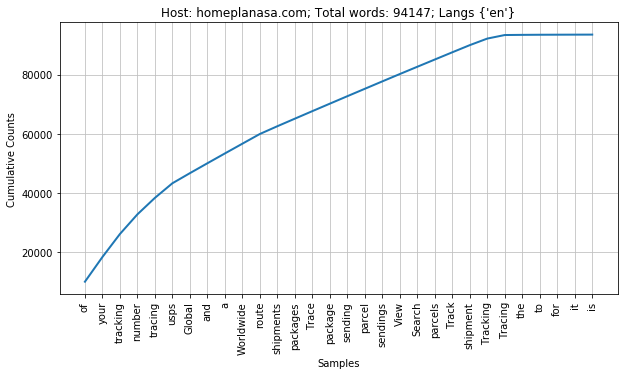

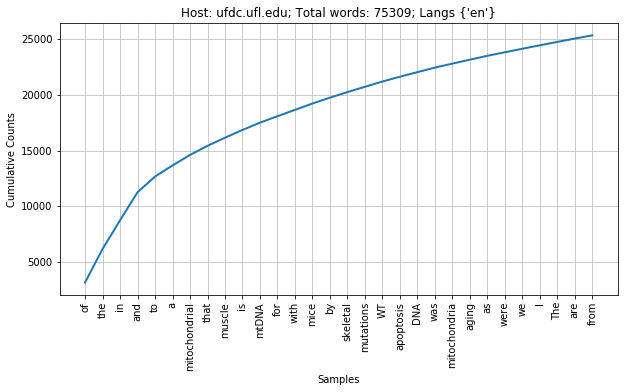

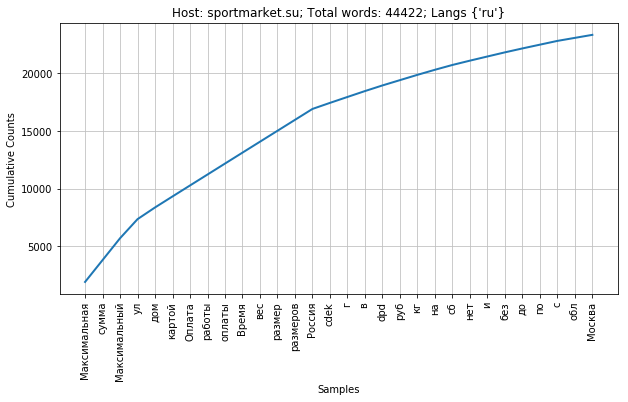

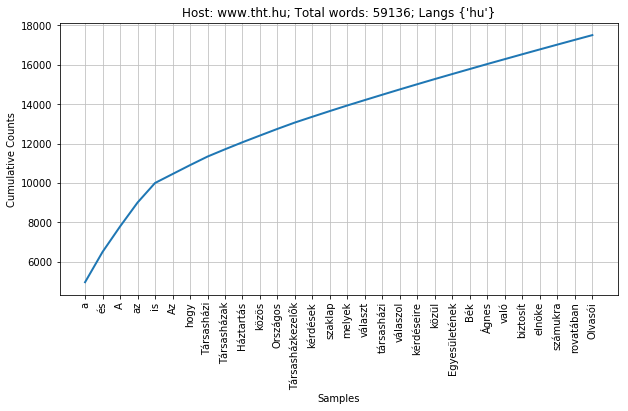

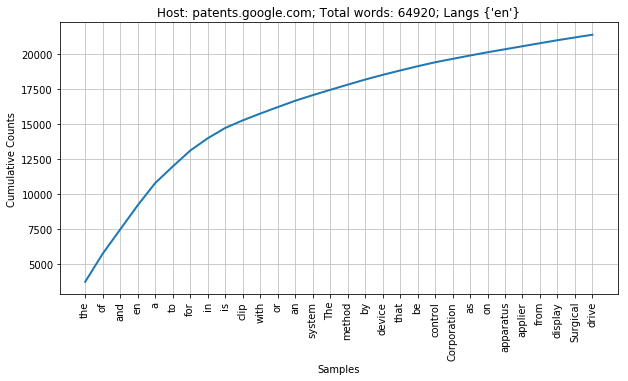

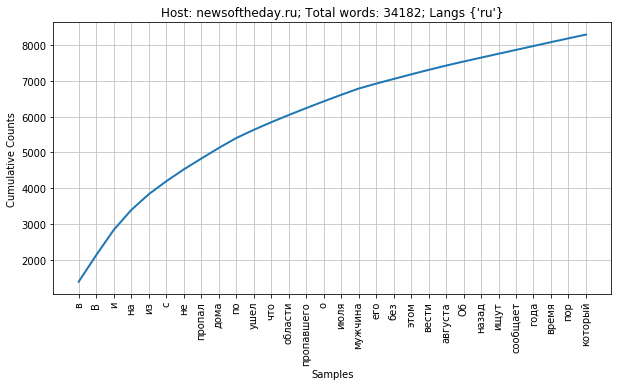

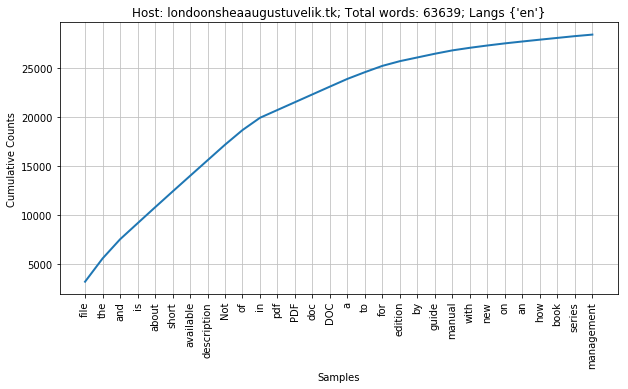

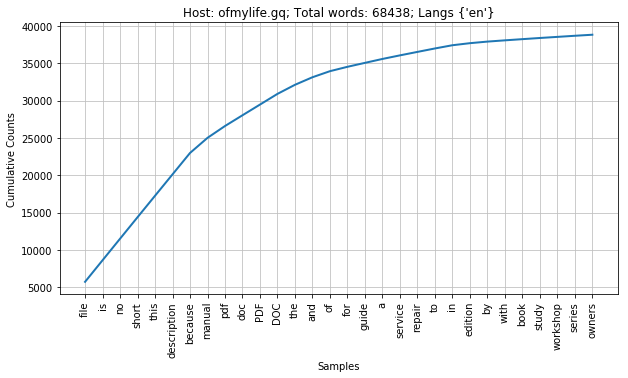

In [130]:
for host in top_hosts.index:
    plot_host_fdist(host)